# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### FEATURES OF DATA 

In [3]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to SCORE in ascending order
# sorted_data=filtered_data.sort_values('Score', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
filtered_data['Score'].value_counts()

1    41788
0     8212
Name: Score, dtype: int64

In [11]:
#Sorting data according to TIME in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
sorted_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to..."


In [13]:
sorted_data['Score'].value_counts()

1    41788
0     8212
Name: Score, dtype: int64

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [15]:
final['Score'].value_counts()

1    38480
0     7592
Name: Score, dtype: int64

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [20]:
x=final.drop('Score',axis=1)
y=final.filter(['Score'],axis=1)

In [21]:
x.shape,y.shape

((46071, 9), (46071, 1))

In [22]:
len(x)

46071

In [23]:
0.7*46071

32249.699999999997

### TIME BASE SPLITTING

In [24]:
32249.699999999997*0.7

22574.789999999997

In [25]:
x_tr=x[:22574]
y_tr=y[:22574]
x_cv=x[22574:32249]
y_cv=y[22574:32249]
x_test=x[32249:]
y_test=y[32249:]

In [26]:
x_tr.shape,y_tr.shape

((22574, 9), (22574, 1))

In [27]:
x_ker=x[:40000]
y_ker=y[:40000]

In [28]:
40000*0.7

28000.0

In [29]:
28000*0.7

19600.0

In [30]:
x_ker_tr=x_ker[:19600]
y_ker_tr=y_ker[:19600]
x_ker_cv=x_ker[19600:28000]
y_ker_cv=y_ker[19600:28000]
x_ker_test=x_ker[28000:]
y_ker_test=y_ker[28000:]

In [31]:
y_tr['Score'].value_counts()

1    19232
0     3342
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [32]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.<br /><br />Try it.  It's a great product.<br /><br /> ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I tried to change my review to 4 stars, but I don't seem able to do that.  These are 3 oz cans of 4 different flavors of fish based catfood.  Chicken and rabbit are often more recommended for cats.  The first ingredient is fish broth, making it s

In [33]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [34]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.Try it.  It's a great product. ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I tried to change my review to 4 stars, but I don't seem able to do that.  These are 3 oz cans of 4 different flavors of fish based catfood.  Chicken and rabbit are often more recommended for cats.  The first ingredient is fish broth, making it somewhat high in moisture

In [35]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [36]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.


In [37]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [38]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The orange and lemon peels make this tea very hippy Despite the initial oohing and ahing over the pretty blue flowers this is a regrettable purchase I was hoping for a stronger bergamot component than Twinings Earl Grey but instead I got something that seems very herbal Blech I disagree with the positive reviews 


In [39]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

#### PREPROCESSING OF TRAIN DATA

In [40]:
def prepro(x):
    # Combining all the above stundents 
    from tqdm import tqdm
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(x['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

### PREPROCESSING TRAIN DATA

In [41]:
preprocessed_reviews=prepro(x_tr)

100%|██████████████████████████████████████████████████████████████████████████| 22574/22574 [00:12<00:00, 1862.61it/s]


### PREPROCESSING CV DATA

In [42]:
preprocessed_reviews_cv=prepro(x_cv)

100%|████████████████████████████████████████████████████████████████████████████| 9675/9675 [00:05<00:00, 1843.57it/s]


### PREPROCESSING TEST DATA

In [43]:
preprocessed_reviews_test=prepro(x_test)

100%|██████████████████████████████████████████████████████████████████████████| 13822/13822 [00:07<00:00, 1858.50it/s]


### PREPROCESSING KERNEL TRAIN DATA

In [44]:
preprocessed_reviews_ker_tr=prepro(x_ker_tr)

100%|██████████████████████████████████████████████████████████████████████████| 19600/19600 [00:10<00:00, 1854.53it/s]


### PREPROCESSING KERNEL CV DATA

In [45]:
preprocessed_reviews_ker_cv=prepro(x_ker_cv)

100%|████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:04<00:00, 1903.81it/s]


### PREPROCESSING KERNEL TEST DATA

In [46]:
preprocessed_reviews_ker_test=prepro(x_ker_test)

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1979.25it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

# FOR LINEAR SVM

#### VECTORIZING FOR  TRAIN DATA IN BOW

In [47]:
#BoW
count_vect = CountVectorizer(max_features=18420) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aachen', 'aadp', 'aaf', 'aafco', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 18420)
the number of unique words  18420


#### VECTORIZING FOR CV DATA IN BOW

In [48]:
#BoW
count_vect.fit(preprocessed_reviews_cv)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_cv = count_vect.transform(preprocessed_reviews_cv)
print("the type of count vectorizer ",type(final_counts_cv))
print("the shape of out text BOW vectorizer ",final_counts_cv.get_shape())
print("the number of unique words ", final_counts_cv.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaah', 'aahs', 'aarthur', 'aback']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9675, 18420)
the number of unique words  18420


#### VECTORIZING FOR TEST DATA IN BOW

In [49]:
 #in scikit-learn
count_vect.fit(preprocessed_reviews_test)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_test= count_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aafco', 'aah', 'aahhhs', 'aback', 'abandoned', 'abates', 'abb']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (13822, 18420)
the number of unique words  18420


## FOR KERNEL SVM

#### VECTORIZING FOR  TRAIN DATA IN BOW

In [50]:
#BoW
count_vect_ker= CountVectorizer(min_df=10,max_features=500) #in scikit-learn
count_vect_ker.fit(preprocessed_reviews_ker_tr)
print("some feature names ", count_vect_ker.get_feature_names()[:10])
print('='*50)

final_counts_ker = count_vect_ker.fit_transform(preprocessed_reviews_ker_tr)
print("the type of count vectorizer ",type(final_counts_ker))
print("the shape of out text BOW vectorizer ",final_counts_ker.get_shape())
print("the number of unique words ", final_counts_ker.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19600, 500)
the number of unique words  500


#### VECTORIZING FOR CV DATA IN BOW

In [51]:
#BoW
count_vect_ker.fit(preprocessed_reviews_ker_cv)
print("some feature names ", count_vect_ker.get_feature_names()[:10])
print('='*50)

final_counts_cv_ker = count_vect_ker.transform(preprocessed_reviews_ker_cv)
print("the type of count vectorizer ",type(final_counts_cv_ker))
print("the shape of out text BOW vectorizer ",final_counts_cv_ker.get_shape())
print("the number of unique words ", final_counts_cv_ker.get_shape()[1])

some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8400, 500)
the number of unique words  500


#### VECTORIZING FOR TEST DATA IN BOW

In [52]:
 #in scikit-learn
count_vect_ker.fit(preprocessed_reviews_ker_test)
print("some feature names ", count_vect_ker.get_feature_names()[:10])
print('='*50)

final_counts_test_ker= count_vect_ker.transform(preprocessed_reviews_ker_test)
print("the type of count vectorizer ",type(final_counts_test_ker))
print("the shape of out text BOW vectorizer ",final_counts_test_ker.get_shape())
print("the number of unique words ", final_counts_test_ker.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almonds', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 500)
the number of unique words  500


## [4.2] Bi-Grams and n-Grams.

In [53]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

## LINEAR SVM

#### TF-IDF FOR TRAIN DATA

In [54]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5990)
tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (22574, 5990)
the number of unique words including both unigrams and bigrams  5990


#### TF-IDF FOR CV DATA

In [55]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit_transform(preprocessed_reviews_cv)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_cv = tf_idf_vect.transform(preprocessed_reviews_cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able use']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9675, 5990)
the number of unique words including both unigrams and bigrams  5990


#### TF-IDF FOR TEST DATA

In [56]:
tf_idf_vect.fit_transform(preprocessed_reviews_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_test = tf_idf_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able buy', 'able eat', 'able find', 'able get', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (13822, 5990)
the number of unique words including both unigrams and bigrams  5990


## KERNEL SVM

In [57]:
tf_idf_vect_ker = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect_ker.fit_transform(preprocessed_reviews_ker_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect_ker.get_feature_names()[0:10])
print('='*50)

final_tf_idf_ker = tf_idf_vect_ker.fit_transform(preprocessed_reviews_ker_tr)
print("the type of count vectorizer ",type(final_tf_idf_ker))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_ker.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_ker.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19600, 500)
the number of unique words including both unigrams and bigrams  500


#### TF-IDF FOR CV DATA

In [58]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_ker.fit_transform(preprocessed_reviews_ker_cv)
print("some sample features(unique words in the corpus)",tf_idf_vect_ker.get_feature_names()[0:10])
print('='*50)

final_tf_idf_cv_ker = tf_idf_vect_ker.transform(preprocessed_reviews_ker_cv)
print("the type of count vectorizer ",type(final_tf_idf_cv_ker))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv_ker.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv_ker.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (8400, 500)
the number of unique words including both unigrams and bigrams  500


#### TF-IDF FOR TEST DATA

In [59]:
tf_idf_vect_ker.fit_transform(preprocessed_reviews_ker_test)
print("some sample features(unique words in the corpus)",tf_idf_vect_ker.get_feature_names()[0:10])
print('='*50)

final_tf_idf_test_ker = tf_idf_vect_ker.transform(preprocessed_reviews_ker_test)
print("the type of count vectorizer ",type(final_tf_idf_test_ker))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test_ker.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test_ker.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.4] Word2Vec

#### w2v for TRAIN DATA

In [60]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [61]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8097169399261475), ('fantastic', 0.7998897433280945), ('good', 0.7975150346755981), ('excellent', 0.7899484634399414), ('terrific', 0.7849385738372803), ('wonderful', 0.7690883278846741), ('perfect', 0.7659608125686646), ('amazing', 0.7048388719558716), ('decent', 0.6845704317092896), ('satisfied', 0.6685174107551575)]
[('ive', 0.8017846345901489), ('best', 0.7953061461448669), ('tastiest', 0.7877910137176514), ('sampled', 0.7383346557617188), ('nastiest', 0.73429274559021), ('eaten', 0.7111603021621704), ('closest', 0.7109853029251099), ('hooked', 0.7103910446166992), ('encountered', 0.6979016065597534), ('beer', 0.6953872442245483)]


In [62]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9130
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'stuff', 'sugar', 'free', 'not', 'rot', 'gums']


#### w2v FOR CV DATA

In [63]:

i=0
list_of_sentance_cv=[]
for sentance in preprocessed_reviews_cv:
    list_of_sentance_cv.append(sentance.split())

In [64]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_cv=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
    print(w2v_model_cv.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_cv.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.8669454455375671), ('good', 0.8494023084640503), ('makes', 0.8051506280899048), ('well', 0.7669053077697754), ('overall', 0.7641651034355164), ('fantastic', 0.761696457862854), ('awesome', 0.7582005858421326), ('right', 0.7565374970436096), ('works', 0.7521684765815735), ('decent', 0.7504843473434448)]
[('favorites', 0.9824845790863037), ('personal', 0.9819837808609009), ('vita', 0.9815971851348877), ('hands', 0.9809101223945618), ('cherry', 0.9806168079376221), ('mate', 0.9805591106414795), ('blueberry', 0.9804791808128357), ('eggnog', 0.9797982573509216), ('beverages', 0.9772326350212097), ('finest', 0.9770099520683289)]


In [65]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_cv))
print("sample words ", w2v_words_cv[0:50])

number of words that occured minimum 5 times  5730
sample words  ['put', 'efficient', 'use', 'researching', 'best', 'organic', 'cat', 'food', 'price', 'found', 'delighted', 'one', 'thing', 'always', 'signed', 'auto', 'ship', 'service', 'stated', 'would', 'able', 'change', 'frequency', 'order', 'time', 'love', 'saves', 'receive', 'free', 'shipping', 'errands', 'especially', 'seemingly', 'endless', 'fabulous', 'idea', 'running', 'scary', 'midnight', 'realize', 'master', 'learned', 'people', 'dogs', 'cats', 'true', 'though', 'remain', 'charge', 'also']


#### w2v FOR TEST DATA

In [66]:
i=0
list_of_sentance_test=[]
for sentance in preprocessed_reviews_test:
    list_of_sentance_test.append(sentance.split())

In [67]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
    print(w2v_model_test.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_test.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.846183180809021), ('good', 0.8266117572784424), ('amazing', 0.7669278979301453), ('awesome', 0.7319532632827759), ('fantastic', 0.7222875952720642), ('wonderful', 0.7191231846809387), ('delicious', 0.7073187828063965), ('super', 0.6862500905990601), ('love', 0.6776154041290283), ('well', 0.673266589641571)]
[('smoothest', 0.9292718768119812), ('compare', 0.9289912581443787), ('dave', 0.9238349199295044), ('name', 0.9229879975318909), ('remember', 0.9221051931381226), ('concentrates', 0.9214602708816528), ('duplicate', 0.9208076596260071), ('admit', 0.9203765392303467), ('fillings', 0.9193471074104309), ('maria', 0.9185217618942261)]


In [68]:
w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  6980
sample words  ['orange', 'peels', 'great', 'tasting', 'love', 'honey', 'added', 'used', 'baking', 'snacking', 'avoderm', 'best', 'dog', 'food', 'found', 'tried', 'many', 'brands', 'last', 'years', 'large', 'dogs', 'keep', 'fit', 'help', 'senior', 'blend', 'bought', 'local', 'grocery', 'store', 'wish', 'would', 'read', 'review', 'first', 'positive', 'hold', 'together', 'well', 'look', 'like', 'muffin', 'negative', 'bitter', 'could', 'barely', 'finish', 'half', 'recently']


### FOR KERNEL SVM


In [69]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_ker=[]
for sentance in preprocessed_reviews_ker_tr:
    list_of_sentance_ker.append(sentance.split())

In [70]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_ker=Word2Vec(list_of_sentance_ker,min_count=5,size=50, workers=4)
    print(w2v_model_ker.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_ker.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8170279860496521), ('awesome', 0.8031275272369385), ('fantastic', 0.8004112839698792), ('excellent', 0.800104022026062), ('wonderful', 0.7980159521102905), ('perfect', 0.7598353624343872), ('decent', 0.7313312292098999), ('delicious', 0.7253332138061523), ('terrific', 0.7174073457717896), ('amazing', 0.7136910557746887)]
[('ive', 0.823634922504425), ('tastiest', 0.8183972835540771), ('sampled', 0.8073025941848755), ('best', 0.8070061802864075), ('encountered', 0.790328860282898), ('greatest', 0.7897909879684448), ('hottest', 0.789413571357727), ('hooked', 0.7886714339256287), ('closest', 0.7757998108863831), ('eaten', 0.7539447546005249)]


In [71]:
w2v_words_ker = list(w2v_model_ker.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_ker))
print("sample words ", w2v_words_ker[0:50])

number of words that occured minimum 5 times  8501
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'stuff', 'sugar', 'free', 'not', 'rot', 'gums']


#### w2v FOR CV DATA

In [72]:
i=0
list_of_sentance_cv_ker=[]
for sentance in preprocessed_reviews_ker_cv:
    list_of_sentance_cv_ker.append(sentance.split())

In [73]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_cv_ker=Word2Vec(list_of_sentance_cv_ker,min_count=5,size=50, workers=4)
    print(w2v_model_cv_ker.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_cv_ker.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.8719509840011597), ('good', 0.8643816709518433), ('makes', 0.8382137417793274), ('fantastic', 0.8201830387115479), ('overall', 0.816028892993927), ('value', 0.8155813217163086), ('tasteful', 0.8047893047332764), ('right', 0.7998217344284058), ('amazing', 0.7774211168289185), ('outstanding', 0.7760794162750244)]
[('popular', 0.9938234090805054), ('pu', 0.9925667643547058), ('cappuccino', 0.9909967184066772), ('er', 0.9909411668777466), ('cola', 0.9901368618011475), ('absolute', 0.9901279807090759), ('midnight', 0.9896441102027893), ('served', 0.9895060062408447), ('blends', 0.9889463186264038), ('emerald', 0.9886804819107056)]


In [74]:
w2v_words_cv_ker= list(w2v_model_cv_ker.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_cv_ker))
print("sample words ", w2v_words_cv_ker[0:50])

number of words that occured minimum 5 times  5495
sample words  ['ordered', 'tea', 'excited', 'thought', 'finally', 'found', 'equal', 'another', 'brand', 'rose', 'individual', 'bags', 'loose', 'quality', 'along', 'anticipated', 'light', 'delicate', 'taste', 'would', 'hoped', 'sadly', 'mistaken', 'opened', 'hit', 'sweet', 'syrupy', 'cotton', 'candy', 'like', 'smell', 'coming', 'bag', 'not', 'good', 'scent', 'determine', 'steeped', 'recommended', 'tablespoons', 'amount', 'time', 'indicated', 'tried', 'overpowering', 'gave', 'bitter', 'reminiscent', 'previous', 'experience']


#### w2v FOR TEST DATA

In [75]:
i=0
list_of_sentance_test_ker=[]
for sentance in preprocessed_reviews_ker_test:
    list_of_sentance_test_ker.append(sentance.split())

In [76]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test_ker=Word2Vec(list_of_sentance_test_ker,min_count=5,size=50, workers=4)
    print(w2v_model_test_ker.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_test_ker.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8551160097122192), ('excellent', 0.8533438444137573), ('amazing', 0.7495375871658325), ('awesome', 0.7477109432220459), ('well', 0.7118093967437744), ('wonderful', 0.7038278579711914), ('decent', 0.702526330947876), ('makes', 0.6874515414237976), ('unbeatable', 0.6658475995063782), ('quick', 0.6609251499176025)]
[('ive', 0.9385446310043335), ('textures', 0.9372638463973999), ('kinds', 0.9347732663154602), ('compares', 0.9341492652893066), ('world', 0.9318863153457642), ('claimed', 0.9314832091331482), ('nip', 0.9284759759902954), ('particular', 0.9275521039962769), ('mate', 0.9264660477638245), ('altoids', 0.9253639578819275)]


In [77]:
w2v_words_test_ker = list(w2v_model_test_ker.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test_ker))
print("sample words ", w2v_words_test_ker[0:50])

number of words that occured minimum 5 times  6517
sample words  ['honest', 'drinking', 'tea', 'life', 'not', 'started', 'pg', 'tips', 'rate', 'worlds', 'best', 'ever', 'go', 'always', 'box', 'case', 'tried', 'lipton', 'omg', 'like', 'dish', 'water', 'want', 'cuppa', 'satisfy', 'thirst', 'worst', 'sure', 'hit', 'everywhere', 'first', 'sip', 'last', 'product', 'suggests', 'european', 'heritage', 'deep', 'southern', 'france', 'seem', 'making', 'calories', 'keurig', 'chai', 'latte', 'actually', 'tastes', 'pretty', 'good']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.4.1.1] Avg W2v

In [78]:
def avgw2v(list_of_sentance,w2v_words,w2v_model):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [79]:
sent_vectors=avgw2v(list_of_sentance,w2v_words,w2v_model)

100%|███████████████████████████████████████████████████████████████████████████| 22574/22574 [01:04<00:00, 351.17it/s]


22574
50


In [80]:
sent_vectors_cv=avgw2v(list_of_sentance_cv,w2v_words_cv,w2v_model_cv)

100%|█████████████████████████████████████████████████████████████████████████████| 9675/9675 [00:16<00:00, 574.63it/s]


9675
50


In [81]:
sent_vectors_test=avgw2v(list_of_sentance_test,w2v_words_test,w2v_model_test)

100%|███████████████████████████████████████████████████████████████████████████| 13822/13822 [00:23<00:00, 584.59it/s]


13822
50


In [82]:
sent_vectors_ker=avgw2v(list_of_sentance_ker,w2v_words_ker,w2v_model_ker)

100%|███████████████████████████████████████████████████████████████████████████| 19600/19600 [00:40<00:00, 482.03it/s]


19600
50


In [83]:
sent_vectors_cv_ker=avgw2v(list_of_sentance_cv_ker,w2v_words_cv_ker,w2v_model_cv_ker)

100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:11<00:00, 740.76it/s]


8400
50


In [84]:
sent_vectors_test_ker=avgw2v(list_of_sentance_test_ker,w2v_words_test_ker,w2v_model_test_ker)

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:20<00:00, 587.29it/s]


12000
50


### [4.4.1.2] TFIDF weighted W2v

#### TFIDF weighted w2v for TRAIN DATA

In [85]:
def tfidfwei_w2v(preprocessed_reviews,list_of_sentance,w2v_words,w2v_model):
    # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(preprocessed_reviews)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf



    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors,model

In [86]:
def tfidfwei_w2v1(model,preprocessed_reviews,list_of_sentance,w2v_words,w2v_model):
    # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    tf_idf_matrix = model.transform(preprocessed_reviews)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf



    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [87]:
tfidf_sent_vectors,model=tfidfwei_w2v(preprocessed_reviews,list_of_sentance,w2v_words,w2v_model)

100%|████████████████████████████████████████████████████████████████████████████| 22574/22574 [09:08<00:00, 33.79it/s]


In [88]:
tfidf_sent_vectors_cv=tfidfwei_w2v1(model,preprocessed_reviews_cv,list_of_sentance_cv,w2v_words_cv,w2v_model_cv)

100%|██████████████████████████████████████████████████████████████████████████████| 9675/9675 [03:27<00:00, 46.55it/s]


In [89]:
tfidf_sent_vectors_test=tfidfwei_w2v1(model,preprocessed_reviews_test,list_of_sentance_test,w2v_words_test,w2v_model_test)

100%|████████████████████████████████████████████████████████████████████████████| 13822/13822 [05:10<00:00, 44.51it/s]


In [90]:
tfidf_sent_vectors_ker,model=tfidfwei_w2v(preprocessed_reviews_ker_tr,list_of_sentance_ker,w2v_words_ker,w2v_model_ker)

100%|████████████████████████████████████████████████████████████████████████████| 19600/19600 [07:19<00:00, 36.40it/s]


In [91]:
tfidf_sent_vectors_ker_cv=tfidfwei_w2v1(model,preprocessed_reviews_ker_cv,list_of_sentance_cv_ker,w2v_words_cv_ker,w2v_model_cv_ker)

100%|██████████████████████████████████████████████████████████████████████████████| 8400/8400 [03:06<00:00, 44.99it/s]


In [92]:
tfidf_sent_vectors_ker_test=tfidfwei_w2v1(model,preprocessed_reviews_ker_test,list_of_sentance_test_ker,w2v_words_test_ker,w2v_model_test_ker)

100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [04:13<00:00, 47.26it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [93]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

c=[10**4,10**3,10**2,10**1,1,10**-1,10**-2,10**-3,10**-4]

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in c:
    clf= SGDClassifier(loss='hinge',alpha=i,class_weight='balanced')
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
    # fitting the model on crossvalidation train
    calibrated_clf.fit(final_counts, y_tr)
    
    # predict the response on the crossvalidation train
    pred = calibrated_clf.predict_proba(final_counts_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = calibrated_clf.predict_proba(final_counts)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)
    print(i)


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.001


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0001


In [94]:
lamb=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [95]:
data1={'alpha':c,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
   alpha=10000

In [96]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
0,10000.0,0.525467,0.749607
1,1000.0,0.525467,0.749607
2,100.0,0.525467,0.749607


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

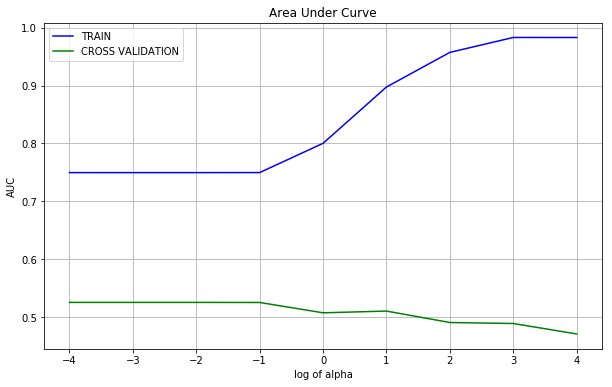

In [131]:
plt.figure(figsize=(10,6))
plt.plot(np.log10(lamb),auc_tr,'b',label='TRAIN')
plt.plot(np.log10(lamb),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [121]:
data_f

,alpha,auc_cv,auc_tr
0,10000.0000,0.525467,0.749607
1,1000.0000,0.525467,0.749607
2,100.0000,0.525467,0.749607
3,10.0000,0.525348,0.749663
4,1.0000,0.507507,0.800189
5,0.1000,0.510501,0.897451
6,0.0100,0.490750,0.957218
7,0.0010,0.489045,0.982967
8,0.0001,0.470955,0.982934


#### TAKEN THE VALUE OF LAPHA AS 10000 BUT IT IS BIASED TOWARDS 1 

In [138]:
# TESTING THE MODEL ON TEST DATA
clf= SGDClassifier(loss='hinge',alpha=100)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
calibrated_clf.fit(final_counts, y_tr)


pred_final = calibrated_clf.predict_proba(final_counts_test)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5315062505509636

In [139]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=calibrated_clf.predict_proba(final_counts)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.5658199610712646

### ROC CURVE

In [140]:
y_a=[0,0.5,1]
x_a=y_a

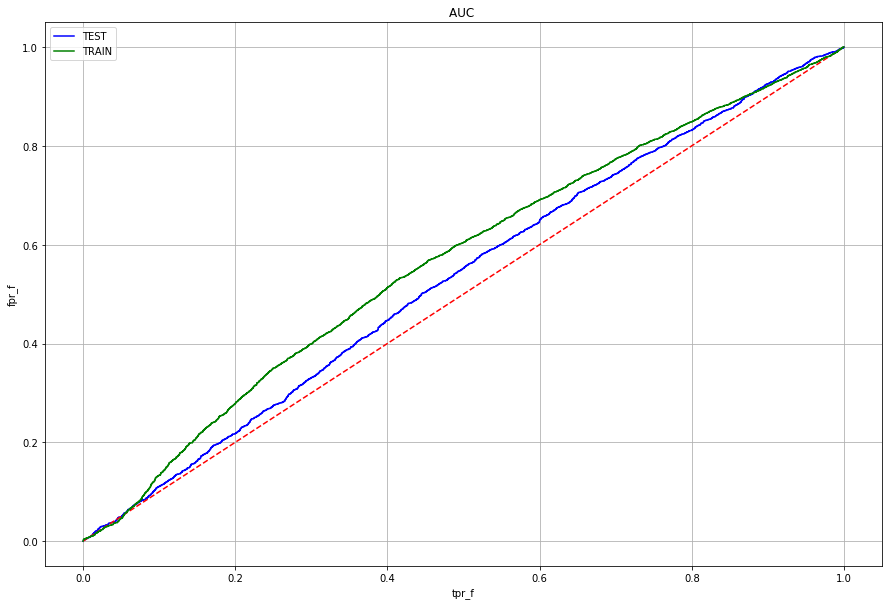

In [141]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [142]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
#             pred_final_class.append(1)
            pred_final_class.append(np.random([0,1]))




In [143]:
cm = confusion_matrix(y_test, pred_final_class)
cm

array([[    0,  2532],
       [    0, 11290]], dtype=int64)

In [144]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

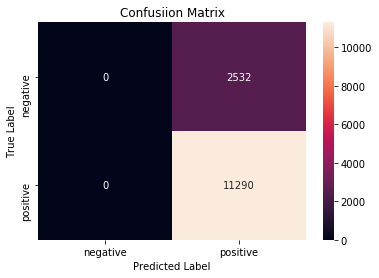

In [137]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_final_class))

              precision    recall  f1-score   support

           0       0.25      0.03      0.05      2532
           1       0.82      0.98      0.89     11290

   micro avg       0.81      0.81      0.81     13822
   macro avg       0.54      0.51      0.47     13822
weighted avg       0.72      0.81      0.74     13822



### Feature Importance on BOW,<font color='red'> SET 1</font>

In [115]:
from sklearn.linear_model import SGDClassifier
clf= SGDClassifier(loss='hinge',alpha=1000)
clf.fit(final_counts, y_tr)

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=1000, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [116]:
w=clf.coef_

In [197]:
w_=np.argsort(w)

In [198]:
features_name=count_vect.get_feature_names()

#### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [199]:
for i in w_[0][-11:]:
    print("{0}   {1}".format(features_name[i],w[0][i]))

exited   0.0001411370633772643
companyis   0.00015801503611634723
thermite   0.0001640397192988026
evenovershadows   0.00016514719782498885
lawsuit   0.00018791695632337744
oquendo   0.0002034216556899895
thing   0.00021959084217232496
flexible   0.0002600359579485586
kibbles   0.0002682755981834161
fish   0.00027660383670031894
nirvana   0.0005577261857876789


#### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [200]:
for i in w_[0][:10]:
    print("{0}   {1}".format(features_name[i],w[0][i]))
    

woke   -5.050102079412199e-06
glitter   -3.9426235532253094e-06
avg   -3.012341591228328e-06
repulsed   -3.0123415912283268e-06
tombstone   -2.8351450270384233e-06
ritz   -2.7465467449434715e-06
tight   -2.3478544755161892e-06
designated   -2.037760488183861e-06
detergent   -1.8605639239939586e-06
designates   -1.6833673598040625e-06


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [145]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

c=[10**4,10**3,10**2,10**1,1,10**-1,10**-2,10**-3,10**-4]

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in c:
    clf= SGDClassifier(loss='hinge',alpha=i)
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
    # fitting the model on crossvalidation train
    calibrated_clf.fit(final_tf_idf, y_tr)
    
    # predict the response on the crossvalidation train
    pred = calibrated_clf.predict_proba(final_tf_idf_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = calibrated_clf.predict_proba(final_tf_idf)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)
    print(i)


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.001


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0001


In [146]:
data1={'alpha':c,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=0.001

In [147]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
7,0.001,0.569488,0.966863


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

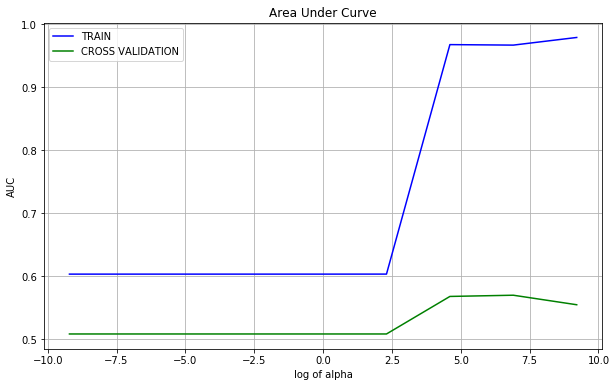

In [148]:
plt.figure(figsize=(10,6))
plt.plot(np.log(lamb),auc_tr,'b',label='TRAIN')
plt.plot(np.log(lamb),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [149]:
data_f

,alpha,auc_cv,auc_tr
0,10000.0000,0.507913,0.603006
1,1000.0000,0.507913,0.603006
2,100.0000,0.507913,0.603006
3,10.0000,0.507913,0.603006
4,1.0000,0.507913,0.603006
5,0.1000,0.507912,0.603036
6,0.0100,0.567550,0.967666
7,0.0010,0.569488,0.966863
8,0.0001,0.554355,0.979017


In [156]:
# TESTING THE MODEL ON TEST DATA
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf= SGDClassifier(loss='hinge',alpha=0.01)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
calibrated_clf.fit(final_tf_idf, y_tr)
pred_final = calibrated_clf.predict_proba(final_tf_idf_test)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6638521346604036

In [157]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=calibrated_clf.predict_proba(final_tf_idf)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.967695005879887

### ROC CURVE

In [158]:
y_a=[0,0.5,1]
x_a=y_a

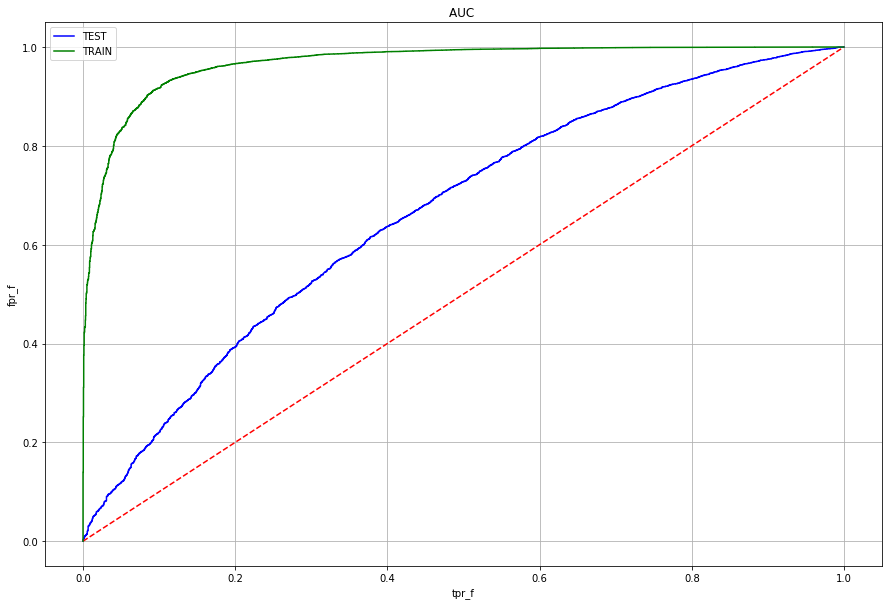

In [159]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [160]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random(1,[0,1]))




In [161]:
cm = confusion_matrix(y_test, pred_final_class)
cm

array([[  486,  2046],
       [  693, 10597]], dtype=int64)

In [162]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

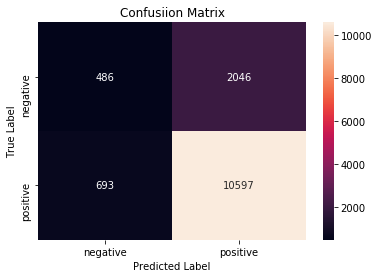

In [163]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [164]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_final_class))

              precision    recall  f1-score   support

           0       0.41      0.19      0.26      2532
           1       0.84      0.94      0.89     11290

   micro avg       0.80      0.80      0.80     13822
   macro avg       0.63      0.57      0.57     13822
weighted avg       0.76      0.80      0.77     13822



### Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [58]:
from sklearn.linear_model import SGDClassifier
clf= SGDClassifier(loss='hinge',alpha=0.001)
clf.fit(final_tf_idf, y_tr)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [59]:
w=clf.coef_

In [60]:
w_=np.argsort(w)

In [61]:
features_name=count_vect.get_feature_names()

#### Top 10 important features of positive class from<font color='red'> SET 2</font>

In [62]:
for i in w_[0][-11:]:
    print("{0}   {1}".format(features_name[i],w[0][i]))

clicker   0.30769277054895044
beheaded   0.31492674033176227
cheesecake   0.31998610261576216
dysfunctional   0.33622115038697814
consisting   0.3383943033927569
cheating   0.37715918436952556
coatings   0.40267451891965594
awesomely   0.45388058615797827
agreeable   0.4570663890722345
bottles   0.47871566166329366
brazilian   0.5748713331196078


#### Top 10 important features of negative class from<font color='red'> SET 2</font>

In [63]:
for i in w_[0][:10]:
    print("{0}   {1}".format(features_name[i],w[0][i]))

easier   -0.9408833796317975
cabernet   -0.8068011282452342
balanced   -0.7395085124704477
advanced   -0.6869036356822764
disguises   -0.6570596946215869
cnn   -0.6265660800306233
crunchy   -0.6215259402327683
disagreement   -0.6111071182164813
drinkable   -0.5958174097797918
comes   -0.5828611939833354


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [165]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

c=[10**4,10**3,10**2,10**1,1,10**-1,10**-2,10**-3,10**-4]

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in c:
    clf= SGDClassifier(loss='hinge',alpha=i)
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
    # fitting the model on crossvalidation train
    calibrated_clf.fit(sent_vectors, y_tr)
    
    # predict the response on the crossvalidation train
    pred = calibrated_clf.predict_proba(sent_vectors_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = calibrated_clf.predict_proba(sent_vectors)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)
    print(i)


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1000


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.001


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0001


In [166]:
data1={'alpha':c,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=0.1

In [203]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
5,0.1,0.77998,0.874989


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

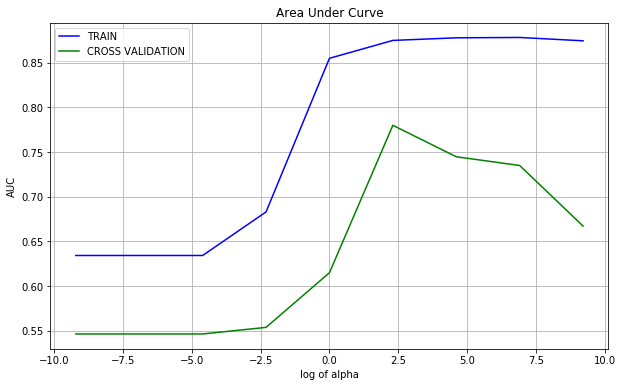

In [205]:
plt.figure(figsize=(10,6))
plt.plot(np.log(lamb),auc_tr,'b',label='TRAIN')
plt.plot(np.log(lamb),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [206]:
# TESTING THE MODEL ON TEST DATA
clf= SGDClassifier(loss='hinge',alpha=.1)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
calibrated_clf.fit(sent_vectors, y_tr)
pred_final = calibrated_clf.predict_proba(sent_vectors_test)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.83084735054718561

In [207]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=calibrated_clf.predict_proba(sent_vectors)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.87653520874843549

### ROC CURVE

In [208]:
y_a=[0,0.5,1]
x_a=y_a

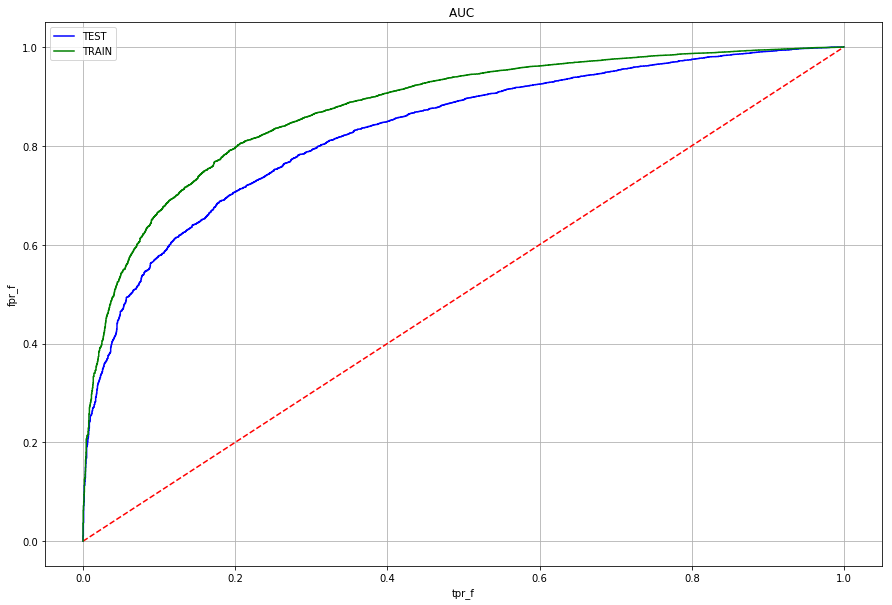

In [209]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [210]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random(1,[0,1]))




In [211]:
cm = confusion_matrix(y_test, pred_final_class)
cm

array([[  528,  2004],
       [  302, 10988]], dtype=int64)

In [212]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

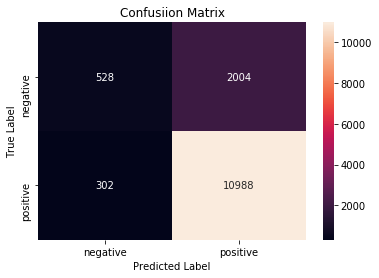

In [213]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [214]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.64      0.21      0.31      2532
          1       0.85      0.97      0.91     11290

avg / total       0.81      0.83      0.80     13822



### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

c=[10**4,10**3,10**2,10**1,1,10**-1,10**-2,10**-3,10**-4]

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in c:
    clf= SGDClassifier(loss='hinge',alpha=i)
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
    # fitting the model on crossvalidation train
    calibrated_clf.fit(tfidf_sent_vectors, y_tr)
    
    # predict the response on the crossvalidation train
    pred = calibrated_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = calibrated_clf.predict_proba(tfidf_sent_vectors)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)
    print(i)


10000
1000
100
10
1
0.1
0.01
0.001
0.0001


In [123]:
lamb=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [124]:
data1={'alpha':c,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=1

In [125]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
4,1.0,0.633855,0.844126


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

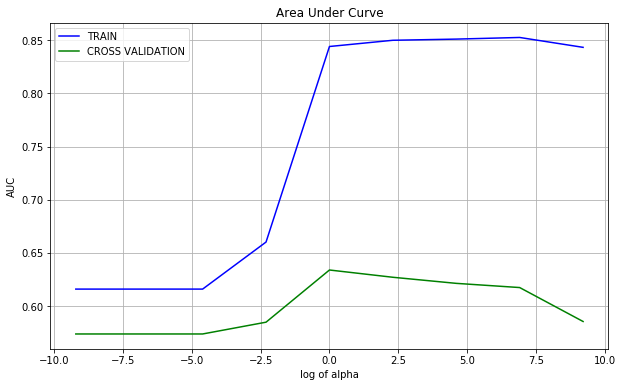

In [126]:
plt.figure(figsize=(10,6))
plt.plot(np.log(lamb),auc_tr,'b',label='TRAIN')
plt.plot(np.log(lamb),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [127]:
# TESTING THE MODEL ON TEST DATA
clf= SGDClassifier(loss='hinge',alpha=1)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
calibrated_clf.fit(sent_vectors, y_tr)
pred_final = calibrated_clf.predict_proba(sent_vectors_test)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.76572660031315709

In [128]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=calibrated_clf.predict_proba(sent_vectors)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.87613004856258925

### ROC CURVE

In [129]:
y_a=[0,0.5,1]
x_a=y_a

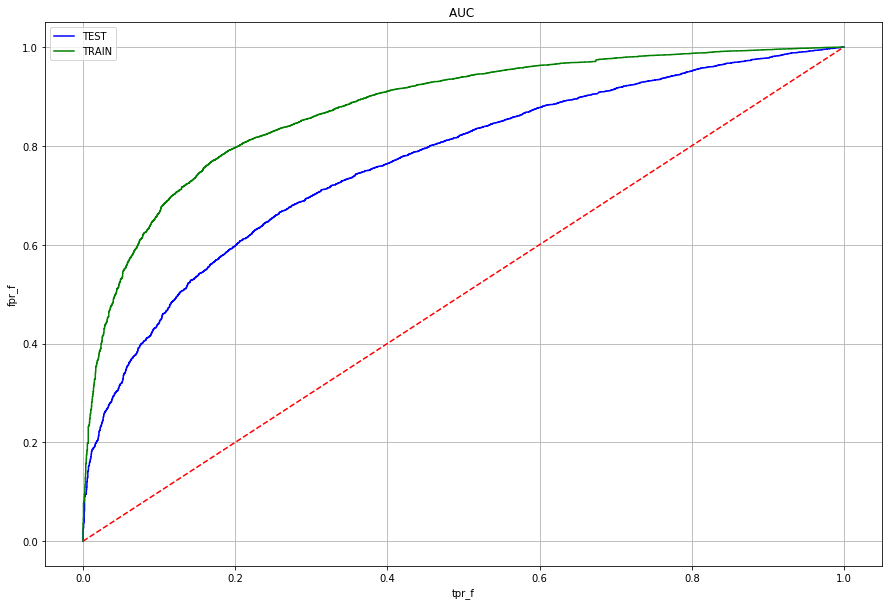

In [130]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [131]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random(1,[0,1]))




In [132]:
cm = confusion_matrix(y_test, pred_final_class)
cm

array([[  841,  1691],
       [ 1094, 10196]], dtype=int64)

In [133]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

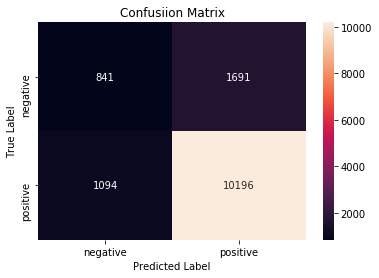

In [134]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [135]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.43      0.33      0.38      2532
          1       0.86      0.90      0.88     11290

avg / total       0.78      0.80      0.79     13822



## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [51]:
from sklearn.svm import SVC

In [52]:
gamma= [10**-2,1,10**2]
c= [10**-2,1,10**2]

In [88]:
auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]
hypermeter=[]
for i in c:
    for j in gamma:
        
        clf=SVC(gamma=j,C=i,probability=True)
        # fitting the model on crossvalidation train
        clf.fit(final_counts_ker, y_ker_tr)

        # predict the response on the crossvalidation train
        pred = clf.predict_proba(final_counts_cv_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_cv, pred)
        auc=metrics.auc(fpr, tpr)
        auc_cv.append(auc)
        tpr_cv.append(tpr)
        fpr_cv.append(fpr)

        # predict the response on the train
        pred = clf.predict_proba(final_counts_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_tr, pred)
        auc=metrics.auc(fpr, tpr)
        auc_tr.append(auc)
        tpr_tr.append(tpr)
        fpr_tr.append(fpr)
        hypermeter.append([i,j])
        print(i,j)
    



0.01 0.01
0.01 1
0.01 100
1 0.01
1 1
1 100
100 0.01
100 1
100 100


In [89]:
c=[]
gamma=[]
for i in range(len(hypermeter)):
    c.append((hypermeter[i])[0])
    gamma.append((hypermeter[i])[1])

In [90]:
data1={'hyperparameter(c,gamma)':hypermeter,'c':c,'gamma':gamma,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=1

In [91]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,auc_cv,auc_tr,c,gamma,"hyperparameter(c,gamma)"
3,0.670859,0.940879,1.0,0.01,"[1, 0.01]"


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

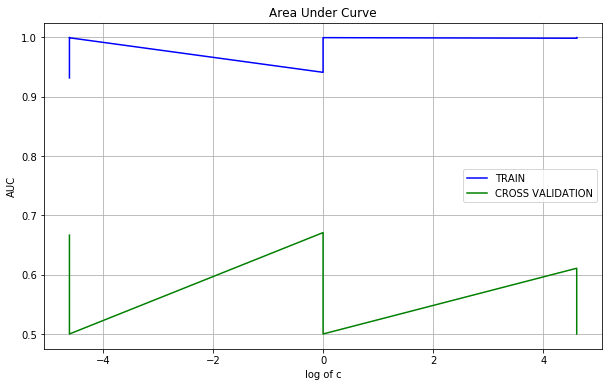

In [92]:
plt.figure(figsize=(10,6))
plt.plot(np.log(c),auc_tr,'b',label='TRAIN')
plt.plot(np.log(c),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of c')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [53]:
# TESTING THE MODEL ON TEST DATA
clf= SVC(gamma=0.01,C=1,probability=True)
clf.fit(final_counts_ker, y_ker_tr)
pred_final = clf.predict_proba(final_counts_test_ker)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_ker_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.70366938167527648

In [55]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=clf.predict_proba(final_counts_ker)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_ker_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.94087937819960332

### ROC CURVE

In [56]:
y_a=[0,0.5,1]
x_a=y_a

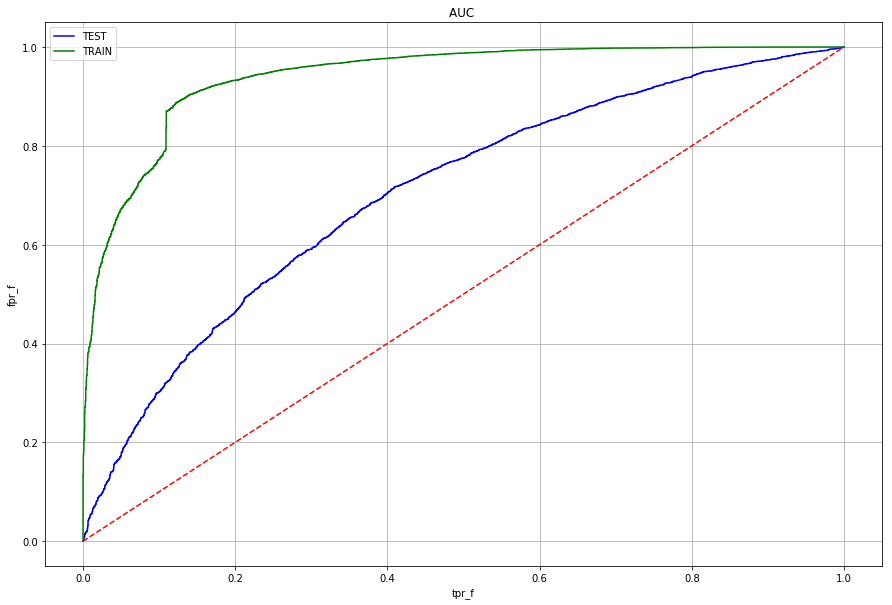

In [57]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [83]:
import numpy as np
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random.randint(2))

# 


In [84]:
cm = confusion_matrix(y_ker_test, pred_final_class)
cm

array([[ 487, 1783],
       [ 642, 9088]], dtype=int64)

In [85]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

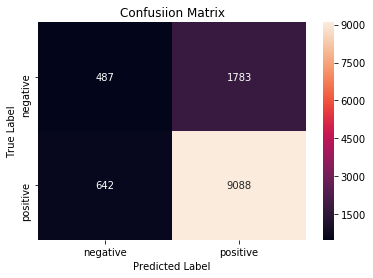

In [86]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_ker_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.43      0.21      0.29      2270
          1       0.84      0.93      0.88      9730

avg / total       0.76      0.80      0.77     12000



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [63]:
from sklearn.svm import SVC

In [64]:
gamma= [10**-2,1,10**2]
c= [10**-2,1,10**2]

In [69]:
auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]
hypermeter=[]
for i in c:
    for j in gamma:
        
        clf=SVC(gamma=j,C=i,probability=True,)
        # fitting the model on crossvalidation train
        clf.fit(final_tf_idf_ker, y_ker_tr)

        # predict the response on the crossvalidation train
        pred = clf.predict_proba(final_tf_idf_cv_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_cv, pred)
        auc=metrics.auc(fpr, tpr)
        auc_cv.append(auc)
        tpr_cv.append(tpr)
        fpr_cv.append(fpr)

        # predict the response on the train
        pred = clf.predict_proba(final_tf_idf_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_tr, pred)
        auc=metrics.auc(fpr, tpr)
        auc_tr.append(auc)
        tpr_tr.append(tpr)
        fpr_tr.append(fpr)
        hypermeter.append([i,j])
        print(i,j)
    



0.01 0.01
0.01 1
0.01 100
1 0.01
1 1
1 100
100 0.01
100 1
100 100


In [70]:
c=[]
gamma=[]
for i in range(len(hypermeter)):
    c.append((hypermeter[i])[0])
    gamma.append((hypermeter[i])[1])

In [71]:
data1={'hyperparameter(c,gamma)':hypermeter,'c':c,'gamma':gamma,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=1

In [72]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,auc_cv,auc_tr,c,gamma,"hyperparameter(c,gamma)"
3,0.5871,0.911225,1.0,0.01,"[1, 0.01]"


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

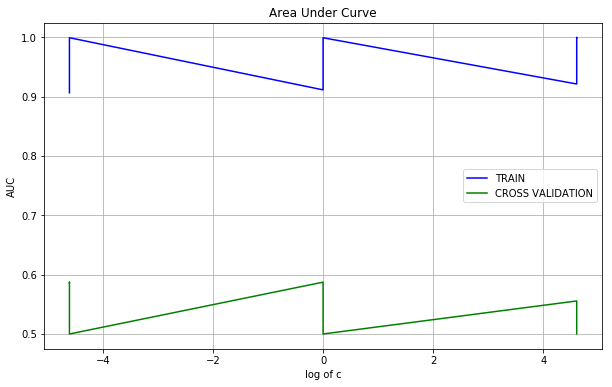

In [73]:
plt.figure(figsize=(10,6))
plt.plot(np.log(c),auc_tr,'b',label='TRAIN')
plt.plot(np.log(c),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of c')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [74]:
# TESTING THE MODEL ON TEST DATA
clf= SVC(gamma=0.01,C=1,probability=True)
clf.fit(final_tf_idf_ker, y_ker_tr)
pred_final = clf.predict_proba(final_tf_idf_test_ker)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_ker_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.67365620656401248

In [75]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=clf.predict_proba(final_tf_idf_ker)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_ker_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.9112218733031614

### ROC CURVE

In [76]:
y_a=[0,0.5,1]
x_a=y_a

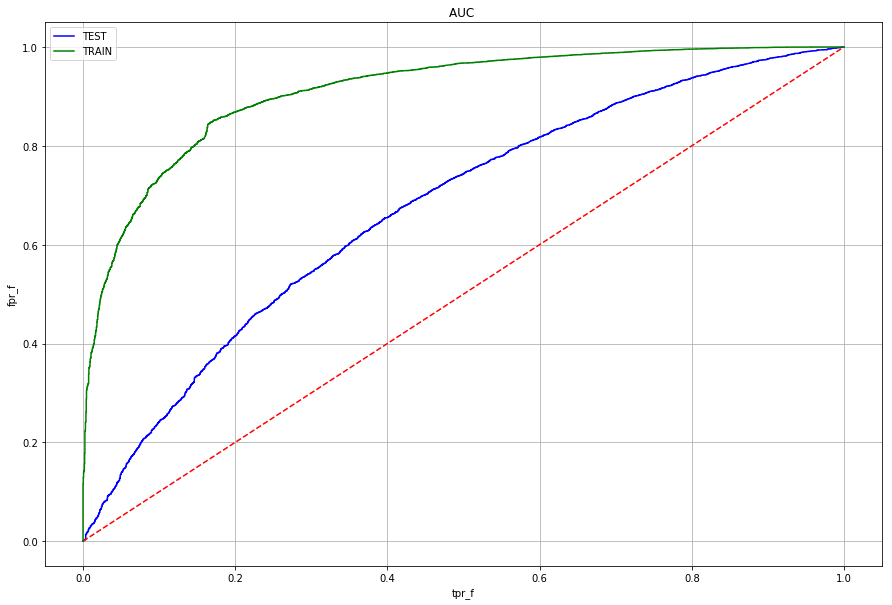

In [77]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [78]:
import numpy as np
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random.randint(2))



In [79]:
cm = confusion_matrix(y_ker_test, pred_final_class)
cm

array([[ 285, 1985],
       [ 327, 9403]], dtype=int64)

In [80]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

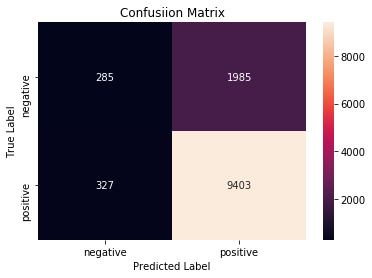

In [81]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_ker_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.47      0.13      0.20      2270
          1       0.83      0.97      0.89      9730

avg / total       0.76      0.81      0.76     12000



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [83]:
from sklearn.svm import SVC

In [84]:
gamma= [10**-2,1,10**2]
c= [10**-2,1,10**2]

In [85]:
auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]
hypermeter=[]
for i in c:
    for j in gamma:
        
        clf=SVC(gamma=j,C=i,probability=True)
        # fitting the model on crossvalidation train
        clf.fit(sent_vectors_ker, y_ker_tr)

        # predict the response on the crossvalidation train
        pred = clf.predict_proba(sent_vectors_cv_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_cv, pred)
        auc=metrics.auc(fpr, tpr)
        auc_cv.append(auc)
        tpr_cv.append(tpr)
        fpr_cv.append(fpr)

        # predict the response on the train
        pred = clf.predict_proba(sent_vectors_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_tr, pred)
        auc=metrics.auc(fpr, tpr)
        auc_tr.append(auc)
        tpr_tr.append(tpr)
        fpr_tr.append(fpr)
        hypermeter.append([i,j])
        print(i,j)
    



0.01 0.01
0.01 1
0.01 100
1 0.01
1 1
1 100
100 0.01
100 1
100 100


In [86]:
c=[]
gamma=[]
for i in range(len(hypermeter)):
    c.append((hypermeter[i])[0])
    gamma.append((hypermeter[i])[1])

In [87]:
data1={'hyperparameter(c,gamma)':hypermeter,'c':c,'gamma':gamma,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=1

In [88]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,auc_cv,auc_tr,c,gamma,"hyperparameter(c,gamma)"
4,0.643319,0.968153,1.0,1.0,"[1, 1]"


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

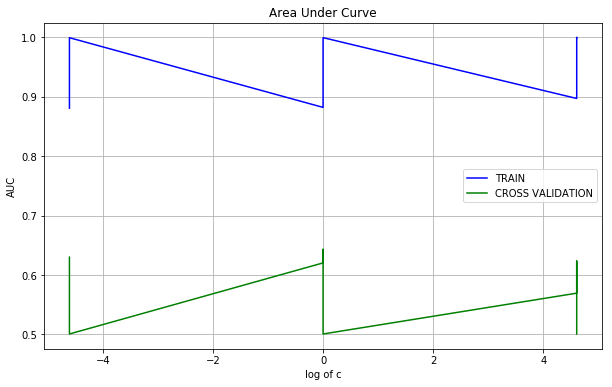

In [89]:
plt.figure(figsize=(10,6))
plt.plot(np.log(c),auc_tr,'b',label='TRAIN')
plt.plot(np.log(c),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of c')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [90]:
# TESTING THE MODEL ON TEST DATA
clf= SVC(gamma=1,C=1,probability=True)
clf.fit(sent_vectors_ker, y_ker_tr)
pred_final = clf.predict_proba(sent_vectors_test_ker)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_ker_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.65550300854344834

In [91]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=clf.predict_proba(sent_vectors_ker)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_ker_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.96815232758109571

### ROC CURVE

In [92]:
y_a=[0,0.5,1]
x_a=y_a

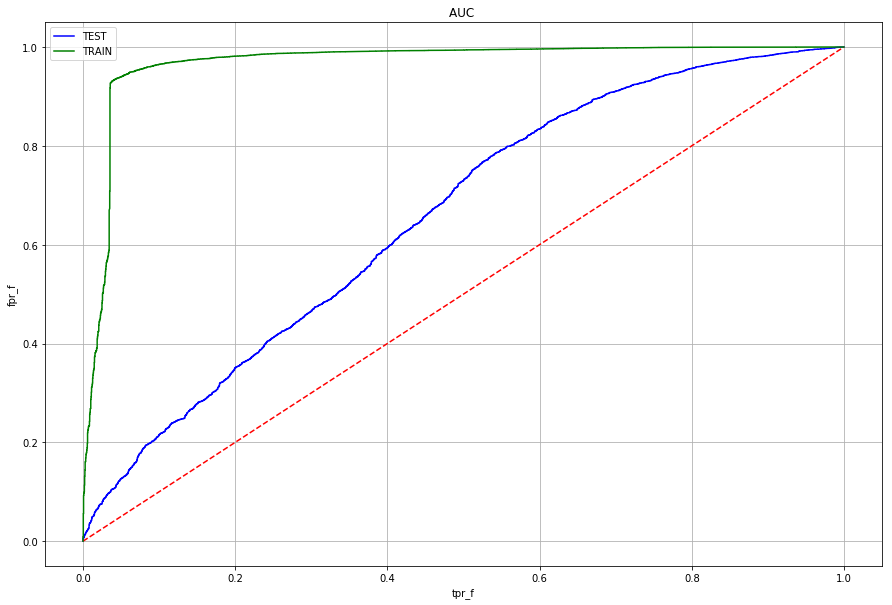

In [93]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [94]:
import numpy as np
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random.randint(2))

# 


In [95]:
cm = confusion_matrix(y_ker_test, pred_final_class)
cm

array([[   4, 2266],
       [   1, 9729]], dtype=int64)

In [96]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

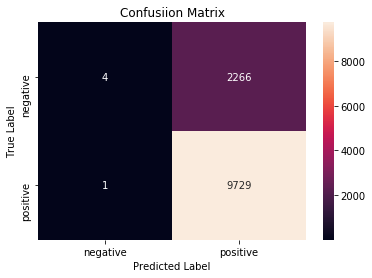

In [97]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_ker_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.80      0.00      0.00      2270
          1       0.81      1.00      0.90      9730

avg / total       0.81      0.81      0.73     12000



### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [99]:
from sklearn.svm import SVC

In [100]:
gamma= [10**-2,1,10**2]
c= [10**-2,1,10**2]

In [101]:
auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]
hypermeter=[]
for i in c:
    for j in gamma:
        
        clf=SVC(gamma=j,C=i,probability=True)
        # fitting the model on crossvalidation train
        clf.fit(tfidf_sent_vectors_ker, y_ker_tr)

        # predict the response on the crossvalidation train
        pred = clf.predict_proba(tfidf_sent_vectors_ker_cv)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_cv, pred)
        auc=metrics.auc(fpr, tpr)
        auc_cv.append(auc)
        tpr_cv.append(tpr)
        fpr_cv.append(fpr)

        # predict the response on the train
        pred = clf.predict_proba(tfidf_sent_vectors_ker)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_ker_tr, pred)
        auc=metrics.auc(fpr, tpr)
        auc_tr.append(auc)
        tpr_tr.append(tpr)
        fpr_tr.append(fpr)
        hypermeter.append([i,j])
        print(i,j)
    



0.01 0.01
0.01 1
0.01 100
1 0.01
1 1
1 100
100 0.01
100 1
100 100


In [102]:
c=[]
gamma=[]
for i in range(len(hypermeter)):
    c.append((hypermeter[i])[0])
    gamma.append((hypermeter[i])[1])

In [103]:
data1={'hyperparameter(c,gamma)':hypermeter,'c':c,'gamma':gamma,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

#### MAXIMUM AUC OF CROSS VALIDATION
     aplha=1

In [104]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,auc_cv,auc_tr,c,gamma,"hyperparameter(c,gamma)"
0,0.608269,0.858691,0.01,0.01,"[0.01, 0.01]"


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

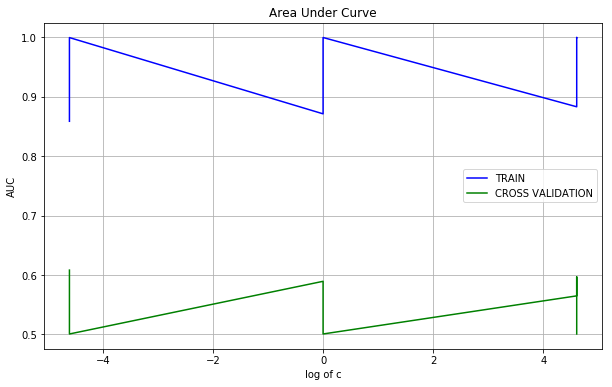

In [105]:
plt.figure(figsize=(10,6))
plt.plot(np.log(c),auc_tr,'b',label='TRAIN')
plt.plot(np.log(c),auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('log of c')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [108]:
# TESTING THE MODEL ON TEST DATA
clf= SVC(gamma=0.01,C=0.01,probability=True)
clf.fit(tfidf_sent_vectors_ker, y_ker_tr)
pred_final = clf.predict_proba(tfidf_sent_vectors_ker_test)[:,1]
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(y_ker_test, pred_final)
auc_final = metrics.auc(fpr_f, tpr_f)
auc_final

0.76398780283513901

In [109]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=clf.predict_proba(tfidf_sent_vectors_ker)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_ker_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.8586901460843035

### ROC CURVE

In [110]:
y_a=[0,0.5,1]
x_a=y_a

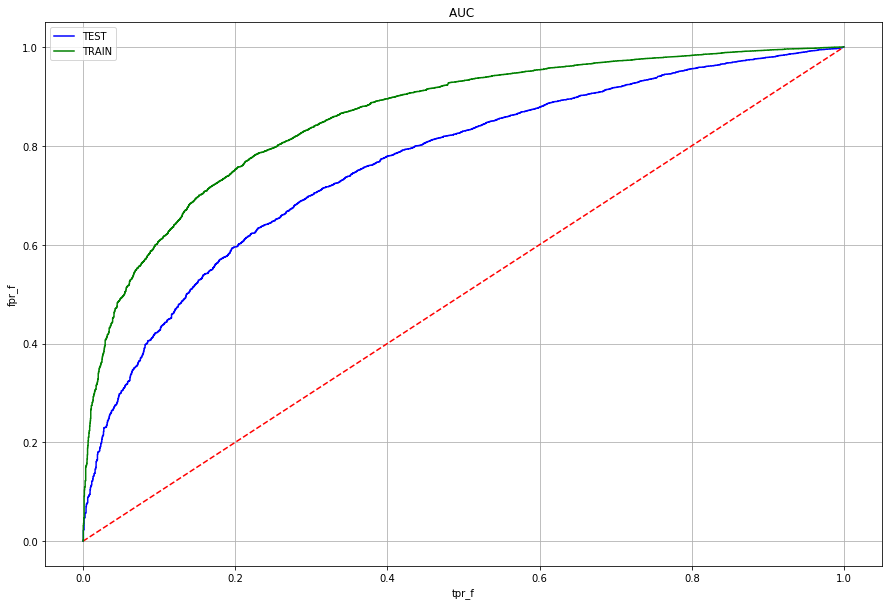

In [111]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [112]:
import numpy as np
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random.randint(2))

# 


In [113]:
cm = confusion_matrix(y_ker_test, pred_final_class)
cm

array([[  83, 2187],
       [  68, 9662]], dtype=int64)

In [114]:
y_test["Score"].value_counts()

1    11290
0     2532
Name: Score, dtype: int64

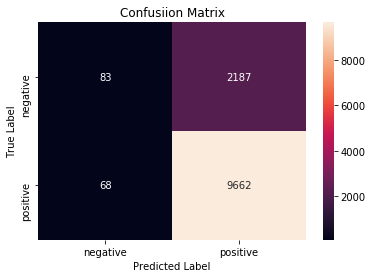

In [115]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [116]:
from sklearn.metrics import classification_report
print(classification_report(y_ker_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.55      0.04      0.07      2270
          1       0.82      0.99      0.90      9730

avg / total       0.77      0.81      0.74     12000



# [6] Conclusions

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["VECTORIZER","Model", "HYPERMETER  [gamma,C]", "AUC"]

x.add_row(["BOW",'SGD', 1000, 0.531507])
x.add_row(["BOW", 'RBF KERNEL', [0.01,1], 0.70367])

x.add_row(["TFIDF", 'SGD',0.001 ,0.669541])
x.add_row(["TFIDF", 'RBF KERNEL',[0.01,1] ,0.6736])

x.add_row(["AVG W2V", 'SGD', 0.1 ,0.830847])
x.add_row(["AVG W2V", 'RBF KERNEL',[1,1],0.6555])

x.add_row(["TFIDF W2V", 'SGD',0.1 , 0.8178])
x.add_row(["TFIDF W2V", 'RBF KERNEL',[0.01,0.01] ,0.76398])



In [2]:
print(x)

+------------+------------+-----------------------+----------+
| VECTORIZER |   Model    | HYPERMETER  [gamma,C] |   AUC    |
+------------+------------+-----------------------+----------+
|    BOW     |    SGD     |          1000         | 0.531507 |
|    BOW     | RBF KERNEL |       [0.01, 1]       | 0.70367  |
|   TFIDF    |    SGD     |         0.001         | 0.669541 |
|   TFIDF    | RBF KERNEL |       [0.01, 1]       |  0.6736  |
|  AVG W2V   |    SGD     |          0.1          | 0.830847 |
|  AVG W2V   | RBF KERNEL |         [1, 1]        |  0.6555  |
| TFIDF W2V  |    SGD     |          0.1          |  0.8178  |
| TFIDF W2V  | RBF KERNEL |      [0.01, 0.01]     | 0.76398  |
+------------+------------+-----------------------+----------+
